In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Device 세팅

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

torch.manual_seed(1)
if device == 'mps':
    torch.mps.manual_seed(1)

print(device)


mps


### 모델 및 학습 정의

In [3]:
DROP_OUT_R = 0.5
LEARNING_RATE = 0.001

EPOCHS = 500
BATCH_SIZE = 50
#VALIDATION_RATE = 0.1

CHECK_INTERVAL = 10
# EARLY_STOP = 30

In [4]:
class CNN_use_VIT(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=30, kernel_size=(1,2)),
            nn.Dropout(DROP_OUT_R),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=30, out_channels=15, kernel_size=(1,2)),
            nn.Dropout(DROP_OUT_R),
            nn.LeakyReLU()
        )

        self.linear_layer = nn.Sequential(
            nn.Linear(15*1*28,1),
            nn.LeakyReLU()
        )

    def forward(self, input_X):
        X1 = self.conv_layer(input_X)
        X1_flatten = X1.view(X1.shape[0], -1)
        y = self.linear_layer(X1_flatten)
        return y

MC_CNN_30K_15K = CNN_use_VIT().to(device)

In [5]:
# 파라미터 개수 확인
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(MC_CNN_30K_15K)) #사용

1426


In [6]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(MC_CNN_30K_15K.parameters(), lr=LEARNING_RATE)

### 학습 과정 정의

In [7]:
train_losses = []

In [8]:
def train_model(train_loader, epochs, check_interval):
    
    for e in range(epochs):
        train_loss = 0
        
        MC_CNN_30K_15K.train()
        for x_batch, y_batch in train_loader:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            pred_y = MC_CNN_30K_15K(x_batch)
            loss = loss_func(pred_y, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    
            
            train_loss += loss.item()

        train_loss = train_loss/len(train_loader)
        train_losses.append(train_loss)
        
        if (e % check_interval) == 0:
            print("epoch : ", e, "train loss: ",train_losses[-1])

### Custom Dataset Type 정의

In [9]:
class BAT_DATASET(Dataset):
    def __init__(self, X, y):
        super().__init__()
        X = deepcopy(X)
        y = deepcopy(y)
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    

    def __getitem__(self, index):
        rX = self.X[index]
        ry = self.y[index]

        return rX, ry
        

### 데이터 묶기 (10개씩)

In [10]:
def prepareXY(X_ndArray, y_ndArray):
   X_data = list()

   for idx in range(0,len(X_ndArray), 10):
      X_data.append(X_ndArray[idx: idx+10].reshape(-1,30))

   X_data = np.array(X_data)

   return X_data, y_ndArray

### ----- ⚠️ 파라미터 불러오기 ------------------------

params = torch.load("../BEST_MODEL/MC_CNN_30K_15K_params.pt")
MC_CNN_30K_15K.load_state_dict(params)

### ----- B0006/B0007/B00018 데이터 학습 ------

In [11]:
def all_data_train_wrapper():
    data_file_indices = ["B0006", "B0007", "B0018"]

    for d_idx in data_file_indices: 
        
        x_df = pd.read_csv(f"../Data/DataFrame/{d_idx}_charge_df.csv").loc[:,["cycle", "voltage_measured", "current_measured", "temperature_measured", "time"]]
        y_df = pd.read_csv(f"../Data/DataFrame/{d_idx}_capacity_df.csv").loc[:,["capacity"]]

        x_df_10points = pd.DataFrame(columns=x_df.columns)

        for cyc in x_df["cycle"].unique():
            tmp_cycle_x_df = x_df[x_df["cycle"] == cyc]
            interval = len(tmp_cycle_x_df.index)//10
            choosed_idx = []
            for idx in range(0,len(tmp_cycle_x_df), interval):
                if len(choosed_idx) == 10 :
                        break
                choosed_idx.append(idx)

            x_df_10points = pd.concat([x_df_10points, tmp_cycle_x_df.iloc[choosed_idx]], axis=0)

        
        display(x_df_10points)

        X_scaler = MinMaxScaler(feature_range=(0,1))
        y_scaler = MinMaxScaler(feature_range=(0,1))

        RAW_XDATA = deepcopy(x_df_10points)
        RAW_yDATA = deepcopy(y_df)

        X_scaled = X_scaler.fit_transform(RAW_XDATA[["voltage_measured", "current_measured", "temperature_measured"]].values.reshape(-1,3))
        y_scaled = y_scaler.fit_transform(RAW_yDATA["capacity"].unique().reshape(-1,1))

        X_data, y_data= prepareXY(X_scaled, y_scaled)
        X_data = torch.from_numpy(X_data).type(torch.float).reshape(X_data.shape[0],1,1,30)
        y_data = torch.from_numpy(y_data).type(torch.float)

        train_dataset = BAT_DATASET(X_data, y_data)

        train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=False)

        train_model(train_loader, EPOCHS, CHECK_INTERVAL)

In [12]:
all_data_train_wrapper()

,cycle,voltage_measured,current_measured,temperature_measured,time
0,2,3.320249,1.515595,31.861155,5.500
76,2,3.772765,1.513079,29.518580,234.078
152,2,3.869867,1.512962,28.012962,511.156
228,2,3.928052,1.515339,27.151827,875.062
304,2,3.968767,1.513685,26.699932,1364.266
...,...,...,...,...,...
375596,169,4.198806,0.349829,25.757573,3460.406
375852,169,4.199172,0.246677,24.935181,4206.797
376108,169,4.199734,0.176216,24.455348,4952.406
376364,169,4.199159,0.129508,24.188771,5697.531


epoch :  0 train loss:  0.20568604161962867
epoch :  10 train loss:  0.0851207785308361
epoch :  20 train loss:  0.07291564252227545
epoch :  30 train loss:  0.04478084947913885
epoch :  40 train loss:  0.04281941428780556
epoch :  50 train loss:  0.038269339594990015
epoch :  60 train loss:  0.028922051191329956
epoch :  70 train loss:  0.02147868857719004
epoch :  80 train loss:  0.021752784261479974
epoch :  90 train loss:  0.021904316963627934
epoch :  100 train loss:  0.01672934601083398
epoch :  110 train loss:  0.019506744807586074
epoch :  120 train loss:  0.018338680267333984
epoch :  130 train loss:  0.01159539632499218
epoch :  140 train loss:  0.013575609773397446
epoch :  150 train loss:  0.015029000816866755
epoch :  160 train loss:  0.014489825232885778
epoch :  170 train loss:  0.009492417681030929
epoch :  180 train loss:  0.011403519660234451
epoch :  190 train loss:  0.015650715678930283
epoch :  200 train loss:  0.010923023510258645
epoch :  210 train loss:  0.01112

,cycle,voltage_measured,current_measured,temperature_measured,time
0,2,3.270404,1.491025,30.573112,5.500
76,2,3.785553,1.491617,28.583428,234.078
152,2,3.881019,1.490421,27.391036,511.156
228,2,3.937696,1.491074,26.781612,875.062
304,2,3.978918,1.490915,26.575697,1364.266
...,...,...,...,...,...
375596,169,4.211561,0.512472,26.321016,3460.406
375852,169,4.212398,0.330517,25.159387,4206.797
376108,169,4.213197,0.224771,24.448661,4952.406
376364,169,4.211974,0.149447,24.056267,5697.531


epoch :  0 train loss:  0.04685370344668627
epoch :  10 train loss:  0.013579515856690705
epoch :  20 train loss:  0.011514660203829408
epoch :  30 train loss:  0.009691882063634694
epoch :  40 train loss:  0.012900464585982263
epoch :  50 train loss:  0.0073083838215097785
epoch :  60 train loss:  0.009540428989566863
epoch :  70 train loss:  0.008703825937118381
epoch :  80 train loss:  0.008424486732110381
epoch :  90 train loss:  0.009406694560311735
epoch :  100 train loss:  0.007822141982614994
epoch :  110 train loss:  0.009759843698702753
epoch :  120 train loss:  0.009475997067056596
epoch :  130 train loss:  0.008199461386539042
epoch :  140 train loss:  0.008359649684280157
epoch :  150 train loss:  0.008594397804699838
epoch :  160 train loss:  0.007484011119231582
epoch :  170 train loss:  0.006206108257174492
epoch :  180 train loss:  0.008387088659219444
epoch :  190 train loss:  0.0072932285838760436
epoch :  200 train loss:  0.006843312177807093
epoch :  210 train loss

,cycle,voltage_measured,current_measured,temperature_measured,time
0,2,3.479525,1.515638,24.286875,5.219
257,2,3.938450,1.516332,24.243205,653.547
514,2,3.997673,1.515629,25.168382,1303.219
771,2,4.049742,1.515579,26.206501,1952.907
1028,2,4.124331,1.517625,27.305446,2602.360
...,...,...,...,...,...
190602,134,4.198443,0.425873,25.797876,3527.000
190702,134,4.198810,0.274652,24.716367,4252.766
190802,134,4.200036,0.192107,24.088869,4977.859
190902,134,4.199606,0.136557,23.701478,5706.000


epoch :  0 train loss:  0.022616827860474586
epoch :  10 train loss:  0.008349664354075989
epoch :  20 train loss:  0.00809411999459068
epoch :  30 train loss:  0.008479341864585876
epoch :  40 train loss:  0.00711544044315815
epoch :  50 train loss:  0.008217459544539452
epoch :  60 train loss:  0.005594243140270312
epoch :  70 train loss:  0.006152822791288297
epoch :  80 train loss:  0.006156279395023982
epoch :  90 train loss:  0.006804397950569789
epoch :  100 train loss:  0.005988488129029672
epoch :  110 train loss:  0.006354966666549444
epoch :  120 train loss:  0.006905687817682822
epoch :  130 train loss:  0.005732984437296788
epoch :  140 train loss:  0.007910470788677534
epoch :  150 train loss:  0.008118799421936274
epoch :  160 train loss:  0.0057392252298692865
epoch :  170 train loss:  0.00599289545789361
epoch :  180 train loss:  0.005312144135435422
epoch :  190 train loss:  0.006054784093673031
epoch :  200 train loss:  0.0054715650621801615
epoch :  210 train loss: 

### ----- ⚠️ 새로운 파라미터 저장 ------------------------

MC_CNN_30K_15K_params = MC_CNN_30K_15K.state_dict()
torch.save(MC_CNN_30K_15K_params, "../BEST_MODEL/MC_CNN_30K_15K_params.pt")

### B0005 예측

In [14]:
x_df = pd.read_csv(f"../Data/DataFrame/B0005_charge_df.csv").loc[:,["cycle", "voltage_measured", "current_measured", "temperature_measured", "time"]]
y_df = pd.read_csv(f"../Data/DataFrame/B0005_capacity_df.csv").loc[:,["capacity"]]

x_df_10points = pd.DataFrame(columns=x_df.columns)
for cyc in x_df["cycle"].unique():
    tmp_cycle_x_df = x_df[x_df["cycle"] == cyc]
    interval = len(tmp_cycle_x_df.index)//10
    choosed_idx = []
    for idx in range(0,len(tmp_cycle_x_df), interval):
        if len(choosed_idx) == 10 :
            break
        choosed_idx.append(idx)

    x_df_10points = pd.concat([x_df_10points, tmp_cycle_x_df.iloc[choosed_idx]], axis=0)    
display(x_df_10points)

X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

RAW_XDATA = deepcopy(x_df_10points)
RAW_yDATA = deepcopy(y_df)

X_scaled = X_scaler.fit_transform(RAW_XDATA[["voltage_measured", "current_measured", "temperature_measured"]].values.reshape(-1,3))
y_scaled = y_scaler.fit_transform(RAW_yDATA["capacity"].unique().reshape(-1,1))
        
X_data, y_data= prepareXY(X_scaled, y_scaled)
X_data = torch.from_numpy(X_data).type(torch.float).reshape(X_data.shape[0],1,1,30)
y_data = torch.from_numpy(y_data).type(torch.float)

test_dataset = BAT_DATASET(X_data, y_data)

test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)

predicts = []

MC_CNN_30K_15K.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
            
        pred_y = MC_CNN_30K_15K(x_batch)

        predicts.append(pred_y.to('cpu'))

predicts_concat = torch.cat(predicts, 0)
predicts_df = pd.DataFrame(y_scaler.inverse_transform(np.array(predicts_concat)))


,cycle,voltage_measured,current_measured,temperature_measured,time
0,2,3.434644,1.508670,29.334717,5.500
76,2,3.814079,1.510073,27.739727,234.078
152,2,3.881686,1.509227,26.890304,511.156
228,2,3.937241,1.508747,26.481944,875.062
304,2,3.979605,1.506559,26.476934,1364.266
...,...,...,...,...,...
375596,169,4.205285,0.409958,26.151950,3460.406
375852,169,4.205106,0.261199,25.147212,4206.797
376108,169,4.204985,0.184375,24.550544,4952.406
376364,169,4.206357,0.135819,24.199547,5697.531


In [15]:
predicts_df

,0
0,1.862561
1,1.867628
2,1.861544
3,1.850696
4,1.846131
...,...
162,1.287236
163,1.287240
164,1.287175
165,1.287196


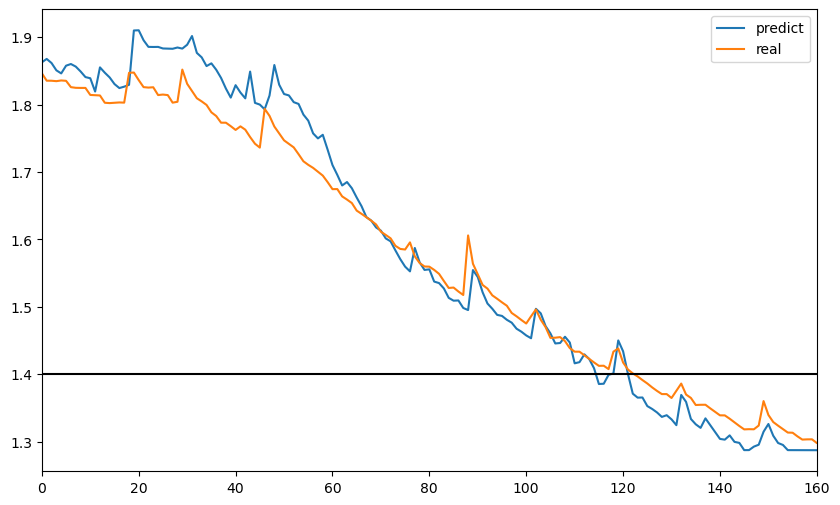

In [16]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 6]
plt.xlim([0, 160])

plt.plot(predicts_df.index, predicts_df.iloc[:,0], label='predict')
plt.plot(range(len(y_df.index)), y_df.iloc[:,0], label='real')
plt.plot(range(len(y_df.index)), [1.4 for i in range(len(y_df.index))], color='black')

plt.legend()
plt.show()

predicts_df.to_csv("../PREDICT/MC_CNN_30K_15K.csv", index = False)